# 1 Data Preperation

In [782]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)


In [783]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


Filter to only 1 and 7

In [784]:
from sklearn import model_selection

mask_1_7 = np.logical_or(target == 1, target == 7)

data_1_7 = data[mask_1_7]
target_1_7 = target[mask_1_7]

X_train_1_7, X_test_1_7, y_train_1_7, y_test_1_7 = model_selection.train_test_split(
    data_1_7, target_1_7, test_size=0.4, random_state=0
)


## 1.1 Dimension Reduction

> To make classification harder (and to simplify the visualization of the feature space),    
> you aresupposed to restrict yourself to 2 feature dimensions.   
> Your dimensionreduction procedure should be callable through a function `reduce_dim`  
> `reduced_x = reduce_dim(x)`   
> where `x` is a `#instances×64` matrix and `reduced_x` has shape  `#instances×2`.

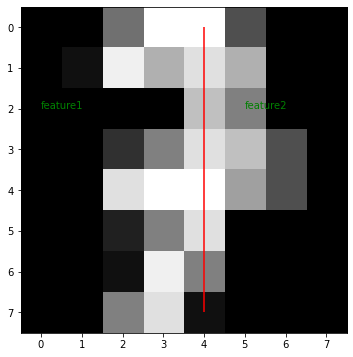

In [785]:
def reduce_dim(
        features_x: np.ndarray
) -> np.ndarray:
    """Reduces the Feature Dimension from #instances×64 to #instances×2.

    Creates f1 and f2 by calulating the mean pixel value of each image, split  verticaly.

    Parameters
    ----------
    features_x : numpy.ndarray
        2D Numpy Array of the size #instances×64

    Returns
    -------
    reduced_features : np.ndarray
        2D Numpy Array of the size #instances×2

    """
    # start by reshaping each 64-len 1d array into
    # a 2d 8x8 array to better represent the image
    features_x = features_x.reshape((-1, 8, 8))
    feature_1 = features_x[:, :, :4].reshape((-1, 32))  # left vertical half
    feature_2 = features_x[:, :, 4:].reshape((-1, 32))  # right vertical half

    # calculate the mean for each row/image
    mean_f1 = feature_1.mean(axis=1)
    mean_f2 = feature_2.mean(axis=1)

    # now return the vstack Transposed, so that the new dimension is #instances×2
    return np.vstack((mean_f1, mean_f2)).T


_example_img = X_test_1_7[7].reshape(8, 8)
plt.figure()
plt.gray()
plt.imshow(_example_img, interpolation="nearest")
plt.vlines(x=4, ymin=0, ymax=7, color="red")
plt.text(x=0, y=2, s="feature1", color="green")
plt.text(x=5, y=2, s="feature2", color="green")
plt.show()


def reduce_dim(x):     return x[:, [60, 19]]


## 1.2  Scatterplot

Text(0, 0.5, 'feature2')

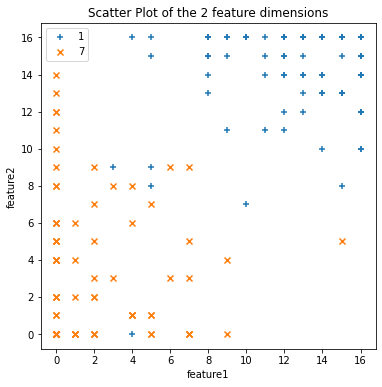

In [786]:
reduced_x = reduce_dim(X_train_1_7)

plt.scatter(
    reduced_x[y_train_1_7 == 1][:, 0],
    reduced_x[y_train_1_7 == 1][:, 1],
    marker="+",
    label="1",
)
plt.scatter(
    reduced_x[y_train_1_7 == 7][:, 0],
    reduced_x[y_train_1_7 == 7][:, 1],
    marker="x",
    label="7",
)
plt.legend()
plt.title("Scatter Plot of the 2 feature dimensions")
plt.xlabel("feature1")
plt.ylabel("feature2")


# 2 Nearest Mean

## 2.1 Implement the nearest mean classifier

In [787]:
def nearest_mean(
    training_features: np.ndarray,
    training_labels: np.ndarray,
    test_features: np.ndarray,
) -> np.ndarray:

    bins = np.ones((test_features.shape[0], 10)) * np.inf  # indices equal the number

    # create means for class 1 and 2 across all their features 1 and 7 respectively
    train_mean_1 = training_features[training_labels == 1].mean(axis=0)
    train_mean_7 = training_features[training_labels == 7].mean(axis=0)

    bins[:, 1] = np.linalg.norm(test_features - train_mean_1, axis=1)
    bins[:, 7] = np.linalg.norm(test_features - train_mean_7, axis=1)

    predicted_labels = np.argmin(bins, axis=1)

    return predicted_labels


## 2.2 Visualize the decision regions

0.006896551724137931


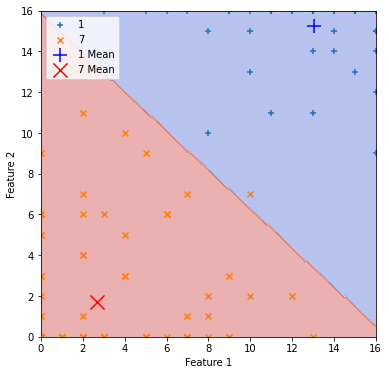

In [788]:
reduced_X_train = reduce_dim(X_train_1_7)
reduced_X_test = reduce_dim(X_test_1_7)

predicted_labels = nearest_mean(reduced_X_train, y_train_1_7, reduced_X_test)
print(np.sum(y_test_1_7 != predicted_labels) / predicted_labels.size)

# draw the decision boundary
step_scale = np.linspace(np.min(reduced_X_train)-0.5, np.max(reduced_X_train)+0.5, 200)
XX, YY = np.meshgrid(step_scale, step_scale)
ZZ = nearest_mean(
    reduced_X_train, y_train_1_7, np.c_[XX.ravel(), YY.ravel()]
).reshape(XX.shape)

plt.contourf(XX, YY, ZZ, cmap=plt.cm.coolwarm, alpha=0.4)

# filter the features by the truth
truth_x_1 = reduced_X_test[y_test_1_7 == 1]
truth_x_7 = reduced_X_test[y_test_1_7 == 7]
# calculate the true means
truth_mean_x_1 = truth_x_1.mean(axis=0) 
truth_mean_x_7 = truth_x_7.mean(axis=0)

# scatter the true features
plt.scatter(truth_x_1[:, 0], truth_x_1[:, 1], marker="+", label="1")
plt.scatter(truth_x_7[:, 0], truth_x_7[:, 1], marker="x", label="7")
# scatter the means
plt.scatter(
    truth_mean_x_1[0], truth_mean_x_1[1], s=200, marker="+", color="Blue", label="1 Mean"
)
plt.scatter(
    truth_mean_x_7[0], truth_mean_x_7[1], s=200, marker="x", color="Red", label="7 Mean"
)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()


# 3 QDA

## 3.1 Implement QDA Training

> The label vector should use label 0 to indicate digit “1” and label 1 to indicate digit “7”.

In [789]:
X_train = X_train_1_7.copy()
y_train = y_train_1_7.copy()
X_test = X_test_1_7.copy()
y_test = y_test_1_7.copy()

y_train[y_train == 1] = 0
y_train[y_train == 7] = 1

y_test[y_test == 1] = 0
y_test[y_test == 7] = 1


In [790]:
def fit_qda(
    training_features: np.ndarray,
    training_labels: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Fit the QDA from the given data set.

    Parameters
    ----------
    training_features : numpy.ndarray
        N×D matrix
    training_labels : numpy.ndarray
        1×N vector, where N is the total number of training instances used.

    Returns
    -------
    mu : numpy.ndarray
        Array of size #classes×D, containing the mean for each feature.
    covmat : numpy.ndarray
        Array of size #classes×D×D, containing the two covariance matrices.
    p : numpy.ndarray
        Array of size 1×D, containing the priors.

    """
    p: np.ndarray = np.bincount(training_labels) / training_labels.size
    mu: np.ndarray = np.array(
        [
            training_features[training_labels == klass].mean(axis=0)
            for klass in range(p.size)
        ]
    )

    covmat: np.ndarray = np.array(
        [
            np.cov(training_features[training_labels == klass].T)
            for klass in range(p.size)
        ]
    )

    return mu, covmat, p


> Apply the fit function to your training data from task 1.1.

In [791]:
reduced_X_test = reduce_dim(X_test)
reduced_X_train = reduce_dim(X_train)

mu, covmat, p = fit_qda(reduced_X_train, y_train)
with np.printoptions(precision=3, suppress=True):
    print(f"{mu=}\n{covmat=}\n{p=}")


mu=array([[13.024, 14.675],
       [ 1.753,  2.892]])
covmat=array([[[10.286,  2.557],
        [ 2.557,  5.975]],

       [[ 7.971,  0.484],
        [ 0.484, 13.771]]])
p=array([0.569, 0.431])


## 3.2 Implement QDA Prediction

In [792]:
def predict_qda(
    mu: np.ndarray,
    covmat: np.ndarray,
    p: np.ndarray,
    test_features: np.ndarray
) -> np.ndarray:
    """Predict using QDA.

    Parameters
    ----------
    mu : numpy.ndarray
        Array of size #classes×D, containing the mean for each feature.
    covmat : numpy.ndarray
        Array of size #classes×D×D, containing the two covariance matrices.
    p : numpy.ndarray
        Array of size 1×D, containing the priors.
    test_features : numpy.ndarray
        Array of size #instances×D, containing the test features to be predicted.


    Returns
    -------
    predicted_labels : numpy.ndarray
        Array of size 1×#instances, containing the predictions for test_features.

    """
    b_ks = 0.5 * np.log(np.linalg.det((2 * np.pi * covmat))) - np.log(p)

    # might be a bit ugly to look at, but damn its fast 👀
    predicted_labels = np.argmin(
        np.array(
            [
                0.5  # 1/2
                * np.sum(
                    (
                        # (x-mu_k) but for the whole array
                        (test_features - mu[klass])
                        * np.linalg.inv(covmat[klass])  # sigma_k ^ -1
                        # default .dot behaviour will be the same as .matmul or @
                        .dot(
                            # (x-mu_k).T but for the whole array
                            (test_features - mu[klass]).T
                        ).T  # Transpose again, because of matmul
                    ),
                    axis=1,
                )
                + b_ks[klass]  # b_k
                for klass in range(p.size)  # for each k
            ]
        ),
        axis=0,
    )

    return predicted_labels


>  Apply the function separately to your training and test data and compute the training and test error rates respectively.

In [793]:
# Test
predicted_labels = predict_qda(mu, covmat, p, reduced_X_test)
print(
    f"Test Error Rate: {np.sum(predicted_labels != y_test)/predicted_labels.size * 100:.3f}%"
)

print("-"*30)
# Train
predicted_labels = predict_qda(mu, covmat, p, reduced_X_train)
print(
    f"Train Error Rate: {np.sum(predicted_labels != y_train)/predicted_labels.size * 100:.3f}%"
)


Test Error Rate: 0.690%
------------------------------
Train Error Rate: 2.778%


## 3.3 Visualization

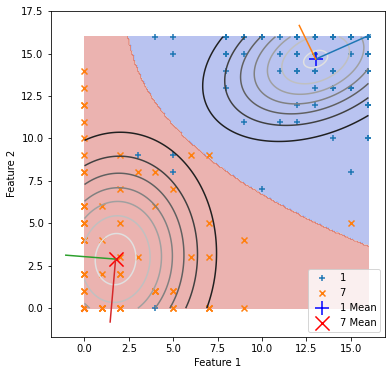

In [794]:
# Start by drawing the decision boundary
step_scale = np.linspace(np.min(reduced_X_train), np.max(reduced_X_train), 200)

XX, YY = np.meshgrid(step_scale, step_scale)
ZZ = predict_qda(
    *fit_qda(reduced_X_train, y_train),
    np.c_[XX.ravel(), YY.ravel()]
).reshape(XX.shape)

plt.contourf(XX, YY, ZZ, cmap=plt.cm.coolwarm, alpha=0.4)  # decisioun boundary

# Filter our features by their truth
truth_x_1 = reduced_X_train[y_train == 0]
truth_x_7 = reduced_X_train[y_train == 1]
# calculate the means for the features


# scatter the truth
plt.scatter(truth_x_1[:, 0], truth_x_1[:, 1], marker="+", label="1")
plt.scatter(truth_x_7[:, 0], truth_x_7[:, 1], marker="x", label="7")

# scatter the truth means
plt.scatter(*mu[0], s=200, marker="+", color="Blue", label="1 Mean")
plt.scatter(*mu[1], s=200, marker="x", color="Red", label="7 Mean")

#################################################################################

# Visualize the Gaussian distributions as contours

features = np.c_[XX.ravel(), YY.ravel()]
Z0 = (
    1 / np.sqrt(np.linalg.det(2 * np.pi * covmat[0]))
    * np.exp(-0.5 * np.sum((features - mu[0])
                           * (np.linalg.inv(covmat[0])
                              @ (features - mu[0]).T).T,
                           axis=1))
).reshape(200, 200)

Z1 = (
    1 / np.sqrt(np.linalg.det(2 * np.pi * covmat[1]))
    * np.exp(-0.5 * np.sum((features - mu[1])
                           * (np.linalg.inv(covmat[1])
                              @ (features - mu[1]).T).T,
                           axis=1))
).reshape(200, 200)


plt.contour(XX, YY, Z0)
plt.contour(XX, YY, Z1)

##############################################################

# eigenvalue/vector decompositions, draw axis on the means

for k, cm in enumerate(covmat):
    eig_vals, eig_vecs = np.linalg.eig(cm)
    std = np.sqrt(eig_vals)

    pos = np.array(
        [mu[k], mu[k] + eig_vecs[:, 0]*np.sqrt(eig_vals[0])]
        )
    plt.plot(pos[:, 0], pos[:, 1])

    pos = np.array(
        [mu[k], mu[k] + eig_vecs[:, 1]*np.sqrt(eig_vals[1])]
        )
    plt.plot(pos[:, 0], pos[:, 1])


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()


`QDA` works on the assumption that our features for each class are normally distributed.  
While the center of our `QDA` regions is represented by the $µ$ for each class, their general shapes will be summarized by the approximated $Σ$.  
So therefore, if our `reduce_dim` function created badly shaped clusters, the `QDA` wont be able to perfectly fit all the data.

The `nearest neighbor` classifier on the other hand will always perfectly classify the training set. Because the features it has to classify will be closest to itself, which it includes, since it was trained on that data.

## 3.4 Performance evaluation

In [795]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator

X_17_10 = data[mask_1_7]
y_17_10 = target[mask_1_7]

X_17_10 = reduce_dim(X_17_10)
y_17_10[y_17_10 == 1] = 0
y_17_10[y_17_10 == 7] = 1


class QDA(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.mu = None
        self.covmat = None
        self.p = None

    def fit(self, X, y):
        self.mu, self.covmat, self.p = fit_qda(X, y)
        self.x = X

    def predict(self, X):
        return predict_qda(self.mu, self.covmat, self.p, X)

    def score(estimator, X, y):
        return np.sum(estimator.predict(X) != y)/y.size


qda_scores = cross_val_score(
    estimator=QDA(),
    X=X_17_10,
    y=y_17_10,
    cv=KFold(n_splits=10, shuffle=True)
)
print(f"{qda_scores.mean()*100:.4f}% mean error rate with a standard deviation of {qda_scores.std()*100:.4f}%")


1.3889% mean error rate with a standard deviation of 1.3889%


# 4 LDA

## 4.1 Implement LDA Training

In [796]:
X_train = X_train_1_7.copy()
y_train = y_train_1_7.copy()
X_test = X_test_1_7.copy()
y_test = y_test_1_7.copy()

y_train[y_train == 1] = 0
y_train[y_train == 7] = 1

y_test[y_test == 1] = 0
y_test[y_test == 7] = 1

In [797]:
def fit_lda(
    training_features: np.ndarray,
    training_labels: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Fit the LDA from the given data set.

    Parameters
    ----------
    training_features : numpy.ndarray
        N×D matrix
    training_labels : numpy.ndarray
        1×N vector, where N is the total number of training instances used.

    Returns
    -------
    mu : numpy.ndarray
        Array of size #classes×D, containing the mean for each feature.
    covmat : numpy.ndarray
        Array of size D×D, containing the two covariance matrices.
    p : numpy.ndarray
        Array of size 1×D, containing the priors.

    """
    p: np.ndarray = np.bincount(training_labels) / training_labels.size
    mu: np.ndarray = np.array(
        [
            training_features[training_labels == klass].mean(axis=0)
            for klass in range(p.size)
        ]
    )

    covmat: np.ndarray = sum(
        np.cov(training_features[training_labels == klass].T, bias=True)
        for klass in range(p.size)
    )/p.size

    return mu, covmat, p


> Applythe fit function to your training data from task 1.1

In [798]:
reduced_X_test = reduce_dim(X_test)
reduced_X_train = reduce_dim(X_train)

mu, covmat, p = fit_lda(reduced_X_train, y_train)
with np.printoptions(precision=3, suppress=True):
    print(f"{mu=}\n{covmat=}\n{p=}")


mu=array([[13.024, 14.675],
       [ 1.753,  2.892]])
covmat=array([[9.044, 1.508],
       [1.508, 9.775]])
p=array([0.569, 0.431])


## 4.2 Implement LDA Predictions

In [799]:
def predict_lda(
    mu: np.ndarray,
    covmat: np.ndarray,
    p: np.ndarray,
    test_features: np.ndarray
) -> np.ndarray:
    """Predict using LDA.

    Parameters
    ----------
    mu : numpy.ndarray
        Array of size #classes×D, containing the mean for each feature.
    covmat : numpy.ndarray
        Array of size D×D, containing the two covariance matrices.
    p : numpy.ndarray
        Array of size 1×D, containing the priors.
    test_features : numpy.ndarray
        Array of size #instances×D, containing the test features to be predicted.


    Returns
    -------
    predicted_labels : numpy.ndarray
        Array of size 1×#instances, containing the predictions for test_features.

    """
    b_ks = 0.5 * np.log(np.linalg.det((2 * np.pi * covmat))) - np.log(p)

    # might be a bit ugly to look at, but damn its fast 👀
    predicted_labels = np.argmin(
        np.array(
            [
                0.5  # 1/2
                * np.sum(
                    (
                        # (x-mu_k) but for the whole array
                        (test_features - mu[klass])
                        * np.linalg.inv(covmat)  # sigma_k ^ -1
                        # default .dot behaviour will be the same as .matmul or @
                        .dot(
                            # (x-mu_k).T but for the whole array
                            (test_features - mu[klass]).T
                        ).T  # Transpose again, because of matmul
                    ),
                    axis=1,
                )
                + b_ks[klass]  # b_k
                for klass in range(p.size)  # for each k
            ]
        ),
        axis=0,
    )

    return predicted_labels

>  Apply the function separately to your training and test data and compute the training and test error rates respectively.

In [800]:
# Test
predicted_labels = predict_lda(mu, covmat, p, reduced_X_test)
print(
    f"Test Error Rate: {np.sum(predicted_labels != y_test)/predicted_labels.size * 100:.3f}%"
)

print("-"*30)
# Train
predicted_labels = predict_lda(mu, covmat, p, reduced_X_train)
print(
    f"Train Error Rate: {np.sum(predicted_labels != y_train)/predicted_labels.size * 100:.3f}%"
)


Test Error Rate: 0.690%
------------------------------
Train Error Rate: 2.778%


## 4.3 Visualization

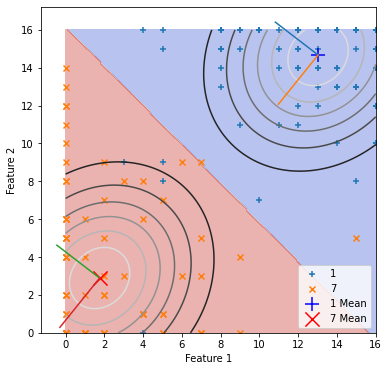

In [801]:
# Start by drawing the decision boundary
step_scale = np.linspace(np.min(reduced_X_train), np.max(reduced_X_train), 200)

XX, YY = np.meshgrid(step_scale, step_scale)
ZZ = predict_lda(
    *fit_lda(reduced_X_train, y_train),
    np.c_[XX.ravel(), YY.ravel()]
).reshape(XX.shape)

plt.contourf(XX, YY, ZZ, cmap=plt.cm.coolwarm, alpha=0.4)  # decisioun boundary

# Filter our features by their truth
truth_x_1 = reduced_X_train[y_train == 0]
truth_x_7 = reduced_X_train[y_train == 1]
# calculate the means for the features


# scatter the truth
plt.scatter(truth_x_1[:, 0], truth_x_1[:, 1], marker="+", label="1")
plt.scatter(truth_x_7[:, 0], truth_x_7[:, 1], marker="x", label="7")

# scatter the truth means
plt.scatter(*mu[0], s=200, marker="+", color="Blue", label="1 Mean")
plt.scatter(*mu[1], s=200, marker="x", color="Red", label="7 Mean")

#################################################################################

# Visualize the Gaussian distributions as contours

features = np.c_[XX.ravel(), YY.ravel()]
Z0 = (
    1 / np.sqrt(np.linalg.det(2 * np.pi * covmat))
    * np.exp(-0.5 * np.sum((features - mu[0])
                           * (np.linalg.inv(covmat)
                              @ (features - mu[0]).T).T,
                           axis=1))
).reshape(200, 200)

Z1 = (
    1 / np.sqrt(np.linalg.det(2 * np.pi * covmat))
    * np.exp(-0.5 * np.sum((features - mu[1])
                           * (np.linalg.inv(covmat)
                              @ (features - mu[1]).T).T,
                           axis=1))
).reshape(200, 200)


plt.contour(XX, YY, Z0)
plt.contour(XX, YY, Z1)

##############################################################

# eigenvalue/vector decompositions, draw axis on the means

for k, cm in enumerate((covmat, covmat)):
    eig_vals, eig_vecs = np.linalg.eig(cm)
    std = np.sqrt(eig_vals)

    pos = np.array(
        [mu[k], mu[k] + eig_vecs[:, 0]*np.sqrt(eig_vals[0])]
    )
    plt.plot(pos[:, 0], pos[:, 1])

    pos = np.array(
        [mu[k], mu[k] + eig_vecs[:, 1]*np.sqrt(eig_vals[1])]
    )
    plt.plot(pos[:, 0], pos[:, 1])


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

## 4.4 Performance evaluation

In [802]:
X_17_10 = data[mask_1_7]
y_17_10 = target[mask_1_7]

X_17_10 = reduce_dim(X_17_10)
y_17_10[y_17_10 == 1] = 0
y_17_10[y_17_10 == 7] = 1


class LDA(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.mu = None
        self.covmat = None
        self.p = None

    def fit(self, X, y):
        self.mu, self.covmat, self.p = fit_lda(X, y)
        self.x = X

    def predict(self, X):
        return predict_lda(self.mu, self.covmat, self.p, X)

    def score(estimator, X, y):
        return np.sum(estimator.predict(X) != y)/y.size


lda_scores = cross_val_score(
    estimator=LDA(),
    X=X_17_10,
    y=y_17_10,
    cv=KFold(n_splits=10, shuffle=True)
)
print(f"{lda_scores.mean():.4f}% mean error rate with a standard deviation of {lda_scores.std():.4f}%")


0.0221% mean error rate with a standard deviation of 0.0208%


> How does the prediction quality change relativeto QDA and the nearest mean classifier?

In [803]:

print(
    f"""QDA
{qda_scores.mean()*100:.4f}% mean error rate with a standard deviation of {qda_scores.std()*100:.4f}%
{"_"*30}
"""
)

print(
    f"""LDA
{lda_scores.mean()*100:.4f}% mean error rate with a standard deviation of {lda_scores.std()*100:.4f}%
{"_"*30}

"""
)


class NM(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.training_features = None
        self.training_labels = None

    def fit(self, X, y):
        self.training_features = X
        self.training_labels = y

    def predict(self, X):
        return nearest_mean(self.training_features, self.training_labels, X)

    def score(estimator, X, y):
        return np.sum(estimator.predict(X) != y)/y.size


nm_scores = cross_val_score(
    estimator=NM(),
    X=reduce_dim(data_1_7),
    y=target_1_7,
    cv=KFold(n_splits=10, shuffle=True)
)
print(
    f"""Nearest Mean
{nm_scores.mean()*100:.4f}% mean error rate with a standard deviation of {nm_scores.std()*100:.4f}%
{"_"*30}

"""
)


QDA
1.3889% mean error rate with a standard deviation of 1.3889%
______________________________

LDA
2.2147% mean error rate with a standard deviation of 2.0768%
______________________________


Nearest Mean
1.6667% mean error rate with a standard deviation of 2.8328%
______________________________


